## SET UP

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import pandas as pd
import sklearn as skl 
import numpy as np
import os
from sklearn.ensemble import HistGradientBoostingClassifier
import matplotlib.pyplot as plt

2023-11-30 08:06:18.278286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# load data 
train_csv = pd.read_csv("./train.csv")

In [3]:
train_csv.head(2)

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False


In [4]:
# count files 


# count = 0
# for _, _, files_list in os.walk('./train_thumbnails/'):
#     count += len(files_list)
# print('file count:', count)


In [5]:
source = './train_thumbnails/'
files_list = os.listdir(source)
labels = train_csv["label"].unique().tolist()
labels_list = train_csv["label"].tolist()

In [6]:
# split images into subfolders TO BE RUN ONCE 
# import shutil
# i=0
# for file in files_list :
#      if (file not in labels ):
#         shutil.move(
#             source + file,
#             f'{source}{labels_list[i]}/'
#             )
#         i += 1

In [7]:
# create data sets
# train_dir = 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/'

BATCH_SIZE = None
# IMG_SIZE = (160, 160)
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            # shuffle=True,
                                                            batch_size=513,
                                                            image_size=IMG_SIZE,
                                                            # subset ="training",
                                                            # validation_split = 0.2,
                                                            seed = 123)

Found 556 files belonging to 5 classes.


## Data visualization

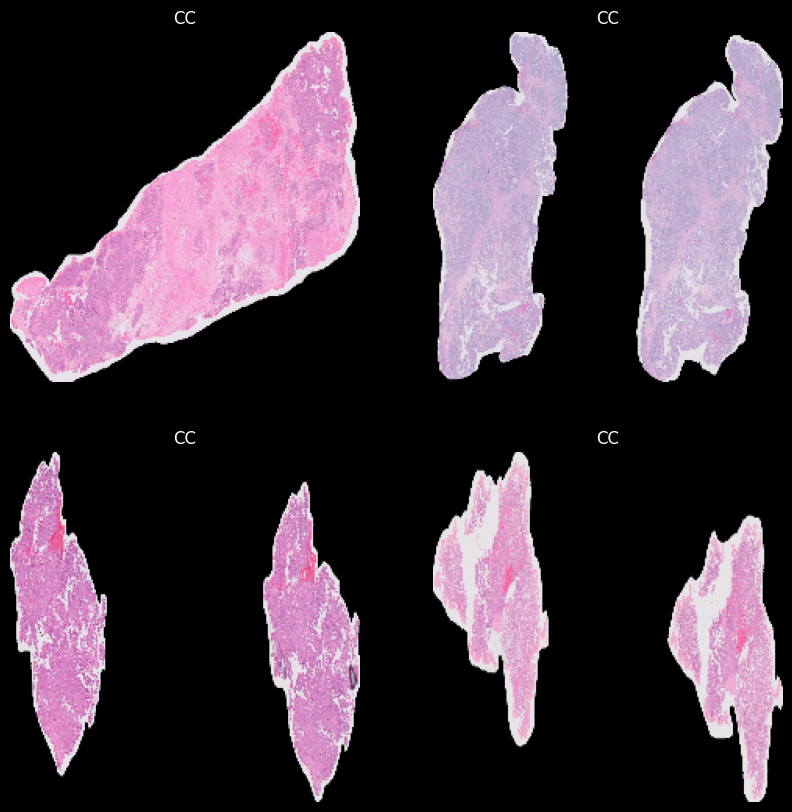

In [8]:
# import matplotlib.pyplot as plt 
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(4):
    # print(class_names[labels[i]])
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

## Transfert learning 

### Features extraction 

pre-trained models list
DenseNet169
vgg19
ResNet101
ResNet50V2


In [10]:
# # create the base pre-trained model
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    # input_tensor=None,
    # input_shape=None,
    # pooling=None,
    classes=5,
    classifier_activation="softmax",
)

In [11]:
base_model.trainable = False

In [12]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input 

In [13]:
train_batches = train_dataset.cardinality().numpy()
# val_batches = validation_dataset.cardinality().numpy()

print(f"num batches : {train_batches}")

num batches : 2


In [14]:
# extract features from train_dataset
# extract images 
train_image,labels_train= next(iter(train_dataset))
batch0 = preprocess_input(train_image)

# extract features 
batch0= base_model.predict(batch0)
shape = batch0.shape

# reshape features 
features_reshaped_train = np.reshape(batch0,(-1,shape[1]*shape[2]*shape[3]))

17/17 [==============================] - 39s 2s/step


In [16]:
# create class weights

weights = skl.utils.class_weight.compute_class_weight('balanced',
                                                      classes = [i for i in range(5)],
                                                    #    y=[class_names[id] for id in labels_train.numpy()] )
                                                       y=labels_train.numpy()
                                                    )
class_weights = {i: round(weights[i],2) for i in range(5) }
class_weights


{0: 1.1, 1: 0.63, 2: 0.57, 3: 2.77, 4: 2.5}

In [17]:
# create models dict
Models = dict()
Scores = dict()


In [18]:
# fit and score function 
def fit_and_score(model,X_train,y_train,X_test,y_test):
    fit = model.fit(X_train,y_train)
    score = fit.score(X_test,y_test)
    return(score)

In [19]:

# split data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# y = [class_names[id] for id in labels_train.numpy()]  

X_train, X_test, y_train, y_test = train_test_split(features_reshaped_train,
                                                    labels_train.numpy(),
                                                    # y,
                                                    test_size=0.2, 
                                                    random_state=2020)

In [20]:
#imports 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree

In [44]:
# Models dict
# glm
Models["glm"] = LogisticRegression(max_iter = 500,
                                   class_weight=class_weights,
                                   random_state=2020)
# # logr reg CV
Models["logRegCV"] = LogisticRegressionCV(cv = 5,max_iter = 500,
                                          class_weight=class_weights,random_state=2020)
# ridge classifier 
# Models["ridgeClf"]= linear_model.RidgeClassifier(alpha=.5,max_iter = 500,
#                                                  class_weight=class_weights,random_state=2020)
# ridge classifier CV
# Models["ridgeCV"]= linear_model.RidgeClassifierCV(alphas = [0.1,0.2,0.3,0.4,0.5,0.6],
                                                # cv = 5,class_weight=class_weights)

# Decision tree
# Models["DT"] = tree.DecisionTreeClassifier(random_state=2020)

# ensemble learner 
# Models["gbst"] = HistGradientBoostingClassifier(max_iter=100)



In [ ]:
#fit and score models 
for model_keys in Models:
    print(model_keys)
    model = Models[model_keys] 
    Scores[model_keys] = fit_and_score(model,X_train,y_train,X_test,y_test)

In [46]:
# yield scores df
scores_df = pd.DataFrame(Scores.values(),
             index = Models.keys(),
             columns = ["scores"]
             )
(scores_df.sort_values(by ="scores",ascending=False)
.head(2)
)

,scores
glm,0.466019
logRegCV,0.446602
ridgeClf,0.446602


In [24]:
# print("pred:",fit.predict(X_test).tolist())
# print("true:",[y_test[i] for i in range(len(y_test))])

In [47]:
os.system('say "end of features extraction" ') 

0

### training on top of pre-trained model

In [84]:
# create data sets
# train_dir = 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/'

BATCH_SIZE = 32
# IMG_SIZE = (160, 160)
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            subset ="training",
                                                            validation_split = 0.2,
                                                            seed = 123)

Found 556 files belonging to 5 classes.
Using 445 files for training.


In [85]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 subset = "validation",
                                                                 validation_split = 0.2,
                                                            seed = 123)

Found 556 files belonging to 5 classes.
Using 111 files for validation.


In [86]:
# test dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [87]:
# Configure datasets for perf
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [88]:
#  augmentation layers
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip('horizontal'),
tf.keras.layers.RandomFlip('vertical'),
tf.keras.layers.RandomFlip('horizontal_and_vertical'),
tf.keras.layers.RandomRotation(factor=0.2),
tf.keras.layers.RandomBrightness(0.2),
#new added layers
tf.keras.layers.RandomCrop(IMG_SIZE[0], IMG_SIZE[1]),
tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
])

In [94]:
# add a global spatial average pooling layer
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)


In [96]:
# this is the model we will train
model = Model(inputs= inputs, outputs=predictions)

In [97]:
len(model.trainable_variables)

2

In [98]:
# compile model 
base_learning_rate = 1e-6
model.compile(tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
# optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics="accuracy")

# tensorboard 
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [99]:
initial_epochs =10

loss0,accuracy0 = model.evaluate(validation_dataset)

2/2 [==============================] - 13s 1s/step - loss: 1.5707 - accuracy: 0.1277


In [100]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False


In [101]:
# train the model on the new data for a few epochs
history = model.fit(train_dataset,
          epochs=initial_epochs,
          validation_data = validation_dataset,
          callbacks=tensorboard_callback,
          use_multiprocessing=True)


Epoch 1/10


14/14 [==============================] - 111s 6s/step - loss: 1.6191 - accuracy: 0.1933 - val_loss: 1.5474 - val_accuracy: 0.1702
Epoch 2/10
14/14 [==============================] - 128s 8s/step - loss: 1.6179 - accuracy: 0.2247 - val_loss: 1.6589 - val_accuracy: 0.1277
Epoch 3/10
14/14 [==============================] - 128s 6s/step - loss: 1.6169 - accuracy: 0.2225 - val_loss: 1.5447 - val_accuracy: 0.1915
Epoch 4/10
14/14 [==============================] - 94s 5s/step - loss: 1.6189 - accuracy: 0.1820 - val_loss: 1.5981 - val_accuracy: 0.1064
Epoch 5/10
14/14 [==============================] - 92s 5s/step - loss: 1.6138 - accuracy: 0.2135 - val_loss: 1.4816 - val_accuracy: 0.1702
Epoch 6/10
14/14 [==============================] - 105s 6s/step - loss: 1.6075 - accuracy: 0.1955 - val_loss: 1.5796 - val_accuracy: 0.1915
Epoch 7/10
14/14 [==============================] - 102s 6s/step - loss: 1.6229 - accuracy: 0.1865 - val_loss: 1.5146 - val_accuracy: 0.2553
Epoch 8/10
14/14 [========

##### learning curve 

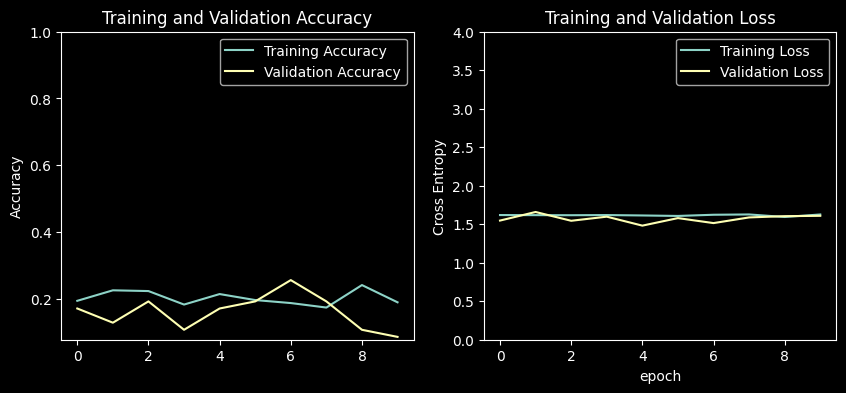

In [102]:
# plot training and validation metrics
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [103]:

os.system('say "end tranfert learning" ')

0

#### Fine-tuning 

In [104]:
# un-freeze model weights
base_model.trainable = True

In [105]:
n_layers = len(base_model.layers)
print(n_layers)


190


In [106]:
n_layers*9//10

171

In [107]:

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
n_trainable_layers = n_layers*9//10
for layer in model.layers[:n_trainable_layers]:
   layer.trainable = False
for layer in model.layers[n_trainable_layers:]:
   layer.trainable = True


#### Recompile model

In [108]:
# from tensorflow.keras.optimizers import SGD
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = "accuracy")

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
          epochs=total_epochs,
          initial_epoch = history.epoch[-1],
          validation_data = validation_dataset,
          callbacks=tensorboard_callback,
          use_multiprocessing=True)

Epoch 10/20
14/14 [==============================] - 129s 7s/step - loss: 1.6011 - accuracy: 0.2382 - val_loss: 1.5770 - val_accuracy: 0.1489
Epoch 11/20
14/14 [==============================] - 111s 6s/step - loss: 1.6073 - accuracy: 0.2090 - val_loss: 1.6254 - val_accuracy: 0.0638
Epoch 12/20
14/14 [==============================] - 122s 7s/step - loss: 1.5986 - accuracy: 0.2157 - val_loss: 1.6020 - val_accuracy: 0.2128
Epoch 13/20
14/14 [==============================] - 127s 7s/step - loss: 1.6011 - accuracy: 0.2202 - val_loss: 1.5843 - val_accuracy: 0.1277
Epoch 14/20
14/14 [==============================] - 128s 7s/step - loss: 1.6094 - accuracy: 0.1843 - val_loss: 1.5295 - val_accuracy: 0.2128
Epoch 15/20
14/14 [==============================] - 120s 7s/step - loss: 1.6012 - accuracy: 0.2090 - val_loss: 1.5638 - val_accuracy: 0.2553
Epoch 16/20
14/14 [==============================] - 115s 6s/step - loss: 1.6142 - accuracy: 0.2045 - val_loss: 1.6594 - val_accuracy: 0.1064
Epoch 

#### Fine-tuning leanrning curve 

In [109]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

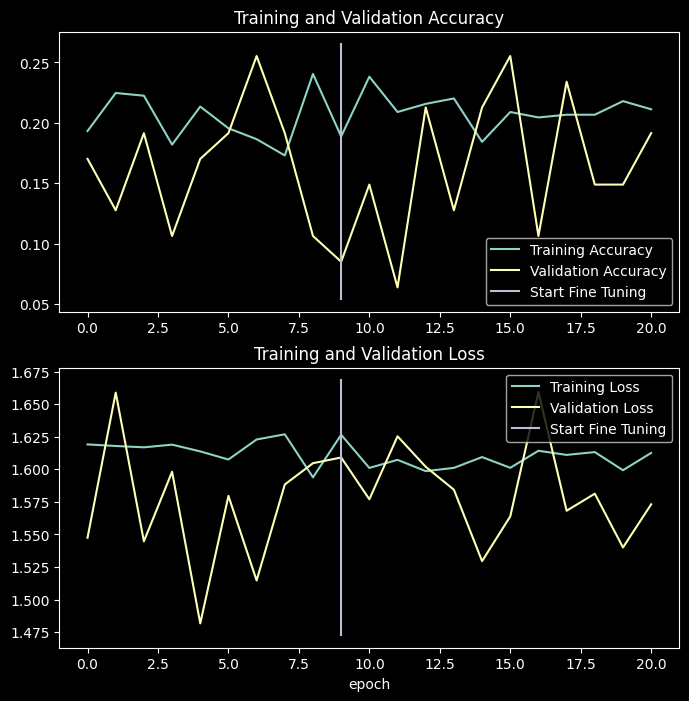

In [110]:
# plot training and validation metrics
import matplotlib.pyplot as plt
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [111]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

In [112]:
test_image_batch,test_label_batch = next(iter(test_dataset))

In [113]:
predicted_batch = model.predict(test_image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1,)
test_labels = [class_names[id] for id in test_label_batch]
predicted_labels = [class_names[id] for id in predicted_id]
print("test labels:",test_labels)
print("pred labels:",predicted_labels)

2023-11-30 10:52:11.180826: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model_4/sequential_2/random_crop_2/cond/branch_executed/_10


1/1 [==============================] - 7s 7s/step
test labels: ['MC', 'HGSC', 'CC', 'EC', 'HGSC', 'MC', 'CC', 'HGSC', 'HGSC', 'EC', 'HGSC', 'EC', 'HGSC', 'CC', 'LGSC', 'EC', 'EC', 'MC', 'EC', 'HGSC', 'HGSC', 'LGSC', 'EC', 'HGSC', 'HGSC', 'EC', 'EC', 'CC', 'CC', 'EC', 'EC', 'EC']
pred labels: ['EC', 'CC', 'CC', 'CC', 'EC', 'EC', 'EC', 'EC', 'CC', 'LGSC', 'CC', 'LGSC', 'LGSC', 'EC', 'LGSC', 'LGSC', 'LGSC', 'LGSC', 'CC', 'CC', 'LGSC', 'LGSC', 'CC', 'EC', 'EC', 'EC', 'HGSC', 'EC', 'EC', 'LGSC', 'LGSC', 'LGSC']



Not quite quite good !!!

## hyper-params tuning : TO DO 

In [114]:
os.system('say "End of fine-tuning"')

0